# Default of Credit Card Clients - Predictive Models

## Introduction

In this report, we will use CatBoost, XGBoost, LightGBM, and deep neural network (DNN) to predict default of credit card clients.

## Dataset

This dataset is downloaded from Kaggle.

Data recource: UCI machine learning repository

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.


## Content
There are 25 variables:

ID: ID of each client

LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit

SEX: Gender (1=male, 2=female)

EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

MARRIAGE: Marital status (1=married, 2=single, 3=others)

AGE: Age in years

PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)

PAY_2: Repayment status in August, 2005 (scale same as above)

PAY_3: Repayment status in July, 2005 (scale same as above)

PAY_4: Repayment status in June, 2005 (scale same as above)

PAY_5: Repayment status in May, 2005 (scale same as above)

PAY_6: Repayment status in April, 2005 (scale same as above)

BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)

BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)

BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)

BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)

BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)

BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)

PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)

PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)

PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)

PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)

PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)

PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)

default.payment.next.month: Default payment (1=yes, 0=no)


# Load packages

## Load packages

In [287]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc #Garbage Collector interface
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

## Set parameters

Here we set few parameters for the analysis and models.

In [288]:
# RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
# NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
# NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
TEST_SIZE = 0.20 # using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2020

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

# Read the data

In [289]:
data_df = pd.read_csv("/Users/Stylewsxcde991/Desktop/Default of Credit Card Clients/UCI_Credit_Card.csv")

# Check the data

In [290]:
print("Default Credit Card Clients data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Default Credit Card Clients data -  rows: 30000  columns: 25


## Glimpse the data

We start by looking to the data features (first 5 rows).

In [291]:
data_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Let's look into more details to the data.

In [292]:
data_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


There are 30,000 distinct credit card clients.  

As the value 0 for default payment means 'not default' and value 1 means 'default', the mean of 0.221 means that there are 22.1% of credit card contracts that will default next month (will verify this in the next sections of this analysis).

## Checking missing data

Let's check if there is any missing data.

In [293]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

By the above information table, we find that all columns have 30000 observations. That is to say, there is no missing data problem.

## Data unbalance

Let's check data unbalance with respect with target value, i.e. default.payment.next.month.

Not_Default 23364
Default 6636
Default proportion 22.12%


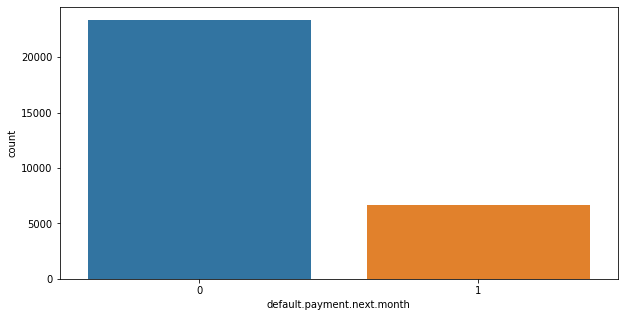

In [294]:
# The proportion of each target class

Not_Default,Default = data_df["default.payment.next.month"].value_counts()
print(f'Not_Default {Not_Default}')
print(f'Default {Default}')
print(f'Default proportion {round((100*Default/(Default+Not_Default)),2)}%')
plt.figure(figsize=(10,5))
sns.countplot(data_df['default.payment.next.month'])

According to above information, a number of 6,636 out of 30,000 (or 22%) of clients will default next month. 

The data has a unbalance with respect of the target value (default.payment.next.month).

This might be a problem for our DNN models.

# Explosive Data exploration

## Features correlation


For the numeric values, let's represent the features correlation.


Let's check the correlation of Amount of bill statement in April - September 2005.

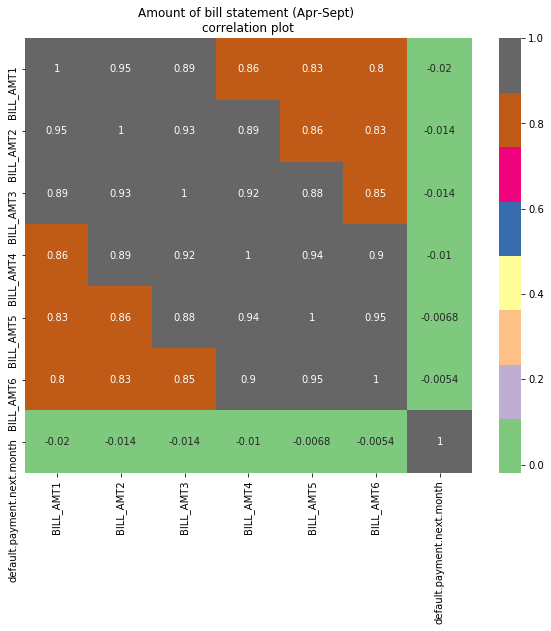

In [513]:
var = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','default.payment.next.month']

plt.figure(figsize=(10,8))  
sns.heatmap(data_df[var].corr(),cmap='Accent',annot=True)
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot')
plt.show()

Correlation is decreasing with distance between months. Lowest correlations are between Sept-April.


Let's check the correlation of Amount of previous payment in April - September 2005.

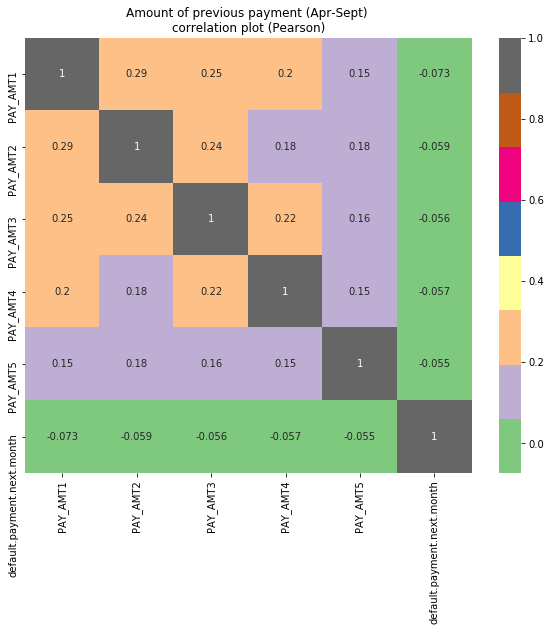

In [512]:
var = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','default.payment.next.month']

plt.figure(figsize=(10,8))  
sns.heatmap(data_df[var].corr(),cmap='Accent',annot=True)
plt.title('Amount of previous payment (Apr-Sept) \ncorrelation plot (Pearson)')
plt.show()

There are no correlations between amounts of previous payments for April-Sept 2005.

Let's check the correlation between Repayment status in April - September 2005.

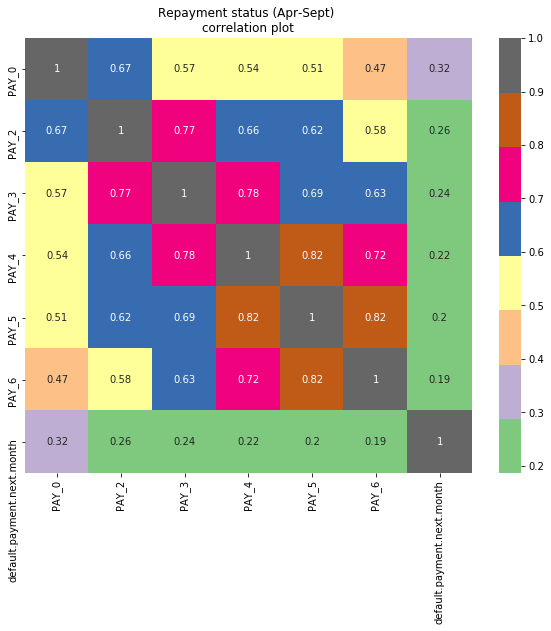

In [514]:
var = ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','default.payment.next.month']

plt.figure(figsize=(10,8))  
sns.heatmap(data_df[var].corr(),cmap='Accent',annot=True)
plt.title('Repayment status (Apr-Sept) \ncorrelation plot')
plt.show()

Correlation is decreasing with distance between months. Lowest correlations are between Sept-April.

## Sex

[Text(0, 0, 'male'), Text(0, 0, 'female')]

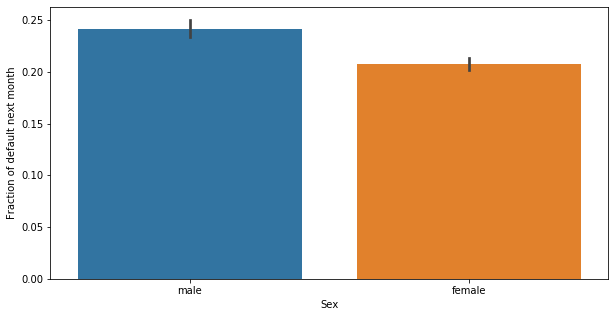

In [298]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='SEX',y='default.payment.next.month',data=data_df)
ax.set(ylabel='Fraction of default next month')
ax.set(xlabel='Sex')
ax.set_xticklabels(['male','female'])

## Education

[Text(0.5, 0, 'Education')]

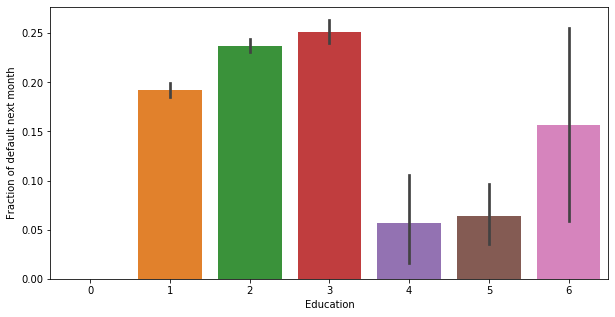

In [299]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='EDUCATION',y='default.payment.next.month',data=data_df)
ax.set(ylabel='Fraction of default next month')
ax.set(xlabel='Education')

## Marriage

[Text(0.5, 0, 'MARRIAGE: 1=married, 2=single, 3=others')]

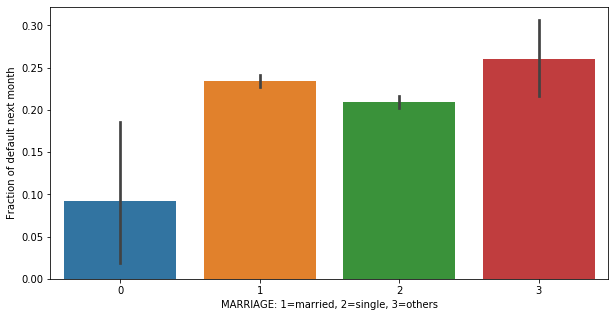

In [300]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='MARRIAGE',y='default.payment.next.month',data=data_df)
ax.set(ylabel='Fraction of default next month')
ax.set(xlabel='MARRIAGE: 1=married, 2=single, 3=others')

## Training set, validation set, and testing set.

Let's define training set, validation set, and testing set.

In [301]:
# Split data_df into training set and testing set
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )

# Split training set into partial training set and validation set.
par_train_df, val_df = train_test_split(train_df,test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )

## Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [302]:
target = 'default.payment.next.month'
predictors = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'EDUCATION', 'SEX',
       'MARRIAGE']

# Define categorical features for catboost and LightGBM
categorical_features =['EDUCATION', 'SEX','MARRIAGE',
                       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6',]

In [303]:
# The whole training set
train_X = train_df[predictors]
train_Y = train_df[target]

# Partial training set
par_train_X = par_train_df[predictors]
par_train_Y = par_train_df[target]

# Validation set
val_X = val_df[predictors]
val_Y = val_df[target]

# Test set
test_X = test_df[predictors]
test_Y = test_df[target]

## One-hot encoder

For xgboost and DNN model, we have use one-hot encoding to encode some categorical variables.

Let's look at columns of our dataset.

In [304]:
data_df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')


There are some categorical features in our data: SEX, EDUCATION, MARRIAGE, AGE, PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6

Here are their definitions:

SEX: Gender (1=male, 2=female)

EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

MARRIAGE: Marital status (1=married, 2=single, 3=others)

PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)

PAY_2: Repayment status in August, 2005 (scale same as above)

PAY_3: Repayment status in July, 2005 (scale same as above)

PAY_4: Repayment status in June, 2005 (scale same as above)

PAY_5: Repayment status in May, 2005 (scale same as above)

PAY_6: Repayment status in April, 2005 (scale same as above)

For PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, these categorical features are ordinal. So label encoding is suitable for these features.

For SEX, EDUCATION, MARRIAGE, I will use one-hot encoding.

In [305]:
OH_features = ['EDUCATION', 'SEX', 'MARRIAGE']

OH_train_X = pd.get_dummies(train_X, columns = OH_features)
OH_par_train_X = pd.get_dummies(par_train_X, columns = OH_features)
OH_val_X = pd.get_dummies(val_X, columns = OH_features)
OH_test_X = pd.get_dummies(test_X, columns = OH_features)

In [306]:
OH_train_X.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION_0', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5',
       'EDUCATION_6', 'SEX_1', 'SEX_2', 'MARRIAGE_0', 'MARRIAGE_1',
       'MARRIAGE_2', 'MARRIAGE_3'],
      dtype='object')

In [307]:
OH_predictors = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION_0', 'EDUCATION_1',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5',
       'EDUCATION_6', 'SEX_1', 'SEX_2', 'MARRIAGE_0', 'MARRIAGE_1',
       'MARRIAGE_2', 'MARRIAGE_3']

# Predictive models

## Choosing a measure of success: metric 

I will use some common metric in this report: accuracy, recall, precision, F1 score.

I use recall, precision, F1 score because our target class is some kind of imbalance.

In [308]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score #The F-Measure is a popular metric for imbalanced classification.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# CatBoostClassifier
CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data

## Prepare the model

Let's set the parameters for the model and initialize the model.

In [262]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='F1',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL, #這個參數是為了不要顯示太多行結果
                             od_wait=100)

## Fit CatBoost

Note that we use the **"categorical_feature"** in our fitting process.

In [263]:
clf.fit(par_train_X, par_train_Y.values,cat_features=categorical_features,eval_set=(val_X,val_Y),verbose=True)

0:	learn: 0.4308878	test: 0.4436137	best: 0.4436137 (0)	total: 63.1ms	remaining: 31.5s
50:	learn: 0.5020447	test: 0.4472362	best: 0.4487744 (48)	total: 23.9s	remaining: 3m 30s
100:	learn: 0.5554865	test: 0.4542626	best: 0.4542626 (100)	total: 56.8s	remaining: 3m 44s
150:	learn: 0.5907186	test: 0.4462399	best: 0.4548287 (110)	total: 1m 22s	remaining: 3m 9s
200:	learn: 0.6084542	test: 0.4491055	best: 0.4548287 (110)	total: 1m 49s	remaining: 2m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4548286604
bestIteration = 110

Shrink model to first 111 iterations.


## Features importance

Let's see the features importance.

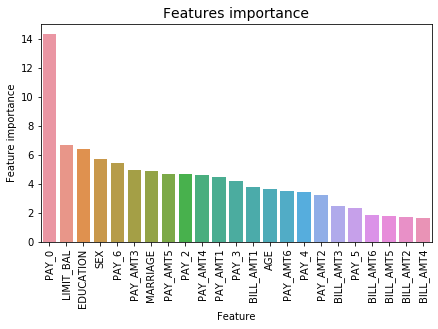

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

## Predict the target values

Let's now predict the **target** values for the **val_df** data, using predict function.

In [233]:
# Use the whole training data to trian our model
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='F1',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL, #這個參數是為了不要顯示太多行結果
                             od_wait=100)

clf.fit(train_X, train_Y.values,eval_set=(val_X,val_Y),verbose=True)

# predict
preds_Y = clf.predict(test_X)

0:	learn: 0.4706761	test: 0.4577861	best: 0.4577861 (0)	total: 421ms	remaining: 3m 30s
50:	learn: 0.5065732	test: 0.4962406	best: 0.4962406 (50)	total: 19s	remaining: 2m 47s
100:	learn: 0.5423010	test: 0.5321674	best: 0.5321674 (100)	total: 37.3s	remaining: 2m 27s
150:	learn: 0.5755021	test: 0.5673671	best: 0.5682520 (146)	total: 55.8s	remaining: 2m 9s
200:	learn: 0.5968457	test: 0.5888138	best: 0.5888138 (200)	total: 1m 15s	remaining: 1m 51s
250:	learn: 0.6179817	test: 0.6107711	best: 0.6107711 (250)	total: 1m 34s	remaining: 1m 34s
300:	learn: 0.6360871	test: 0.6252285	best: 0.6252285 (300)	total: 1m 54s	remaining: 1m 15s
350:	learn: 0.6526367	test: 0.6363636	best: 0.6363636 (350)	total: 2m 13s	remaining: 56.8s
400:	learn: 0.6730608	test: 0.6598802	best: 0.6598802 (399)	total: 2m 32s	remaining: 37.8s
450:	learn: 0.6936595	test: 0.6769231	best: 0.6769231 (450)	total: 2m 52s	remaining: 18.8s
499:	learn: 0.7113826	test: 0.6996508	best: 0.7012231 (495)	total: 3m 12s	remaining: 0us

bestTe

## Confusion matrix, accuracy, precision, recall, F1 score

In [234]:
accuracy = accuracy_score(test_Y, preds_Y)
precision = precision_score(test_Y, preds_Y)
recall = recall_score(test_Y, preds_Y)
f1 = f1_score(test_Y, preds_Y)
c_matrix = confusion_matrix(test_Y, preds_Y)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8221666666666667

precision: 0.7217261904761905

recall: 0.3553113553113553

F1 score: 0.47619047619047616

Confusion matrix: 
[[4448  187]
 [ 880  485]]


# XGBoostClassifier
XGBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data

## Prepare and fit the model

In [270]:
clf = xgb.XGBClassifier(learning_rate=0.02)
clf.fit(par_train_X, par_train_Y,eval_set=[(par_train_X,par_train_Y),(val_X,val_Y)],early_stopping_rounds=10, verbose=True)

[0]	validation_0-error:0.16969	validation_1-error:0.18396
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.16974	validation_1-error:0.18396
[2]	validation_0-error:0.16964	validation_1-error:0.18396
[3]	validation_0-error:0.16984	validation_1-error:0.18396
[4]	validation_0-error:0.16990	validation_1-error:0.18396
[5]	validation_0-error:0.16990	validation_1-error:0.18396
[6]	validation_0-error:0.16906	validation_1-error:0.18354
[7]	validation_0-error:0.16953	validation_1-error:0.18354
[8]	validation_0-error:0.16891	validation_1-error:0.18333
[9]	validation_0-error:0.16891	validation_1-error:0.18333
[10]	validation_0-error:0.16885	validation_1-error:0.18333
[11]	validation_0-error:0.16875	validation_1-error:0.18313
[12]	validation_0-error:0.16870	validation_1-error:0.18313
[13]	validation_0-error:0.16875	validation_1-error:0.18271
[14]	validation_0-error

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

## Features importance

Let's see the features importance.

In [271]:
clf.feature_importances_

array([0.00948596, 0.00432746, 0.7013907 , 0.11981683, 0.01353244,
       0.01157393, 0.02505312, 0.01070786, 0.01198352, 0.00545711,
       0.00460776, 0.00524404, 0.00365825, 0.005003  , 0.00591743,
       0.00847558, 0.02381752, 0.00598348, 0.00435658, 0.00531497,
       0.00706675, 0.        , 0.00722563], dtype=float32)

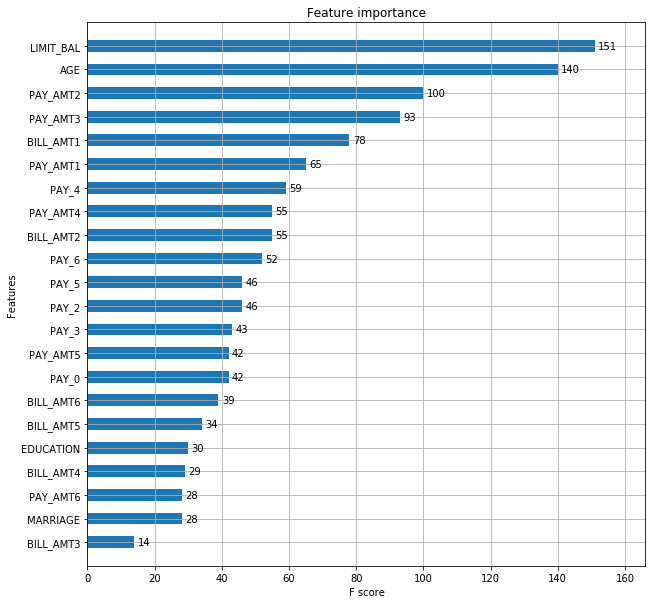

In [274]:
fig,ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(clf,height=0.5,ax=ax)

## Predict the target values

In [269]:
# Use the whole data set to train our model
clf.fit(OH_train_X, train_Y)

# predict the results
preds_Y=clf.predict(OH_test_X)

## Confusion matrix, accuracy, precision, recall, F1 score

In [251]:
preds_Y=(preds_Y>0.5).astype(int)

accuracy = accuracy_score(test_Y, preds_Y)
precision = precision_score(test_Y, preds_Y)
recall = recall_score(test_Y, preds_Y)
f1 = f1_score(test_Y, preds_Y)
c_matrix = confusion_matrix(test_Y, preds_Y)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8188333333333333

precision: 0.7044117647058824

recall: 0.3509157509157509

F1 score: 0.4684596577017115

Confusion matrix: 
[[4434  201]
 [ 886  479]]


# LightBGM Classifier

Let's continue with LightGBM classifier.

## Prepare and fit the model

Note that we use the "categorical_feature" parameter.

In [276]:
clf = lgb.LGBMClassifier()
clf.fit(par_train_X, par_train_Y,eval_set=[(par_train_X,par_train_Y),(val_X,val_Y)],
        early_stopping_rounds=10, verbose=True,categorical_feature=categorical_features)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'SEX']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's binary_logloss: 0.50461	valid_1's binary_logloss: 0.510877
Training until validation scores don't improve for 10 rounds
[2]	training's binary_logloss: 0.489156	valid_1's binary_logloss: 0.496524
[3]	training's binary_logloss: 0.476756	valid_1's binary_logloss: 0.485603
[4]	training's binary_logloss: 0.466744	valid_1's binary_logloss: 0.476619
[5]	training's binary_logloss: 0.458496	valid_1's binary_logloss: 0.469308
[6]	training's binary_logloss: 0.451498	valid_1's binary_logloss: 0.463626
[7]	training's binary_logloss: 0.445647	valid_1's binary_logloss: 0.458814
[8]	training's binary_logloss: 0.440528	valid_1's binary_logloss: 0.454839
[9]	training's binary_logloss: 0.436143	valid_1's binary_logloss: 0.451608
[10]	training's binary_logloss: 0.432177	valid_1's binary_logloss: 0.449173
[11]	training's binary_logloss: 0.428814	valid_1's binary_logloss: 0.447153
[12]	training's binary_logloss: 0.425591	valid_1's binary_logloss: 0.444943
[13]	training's binary_logloss: 0.422

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Features importance

Let's see the features importance.

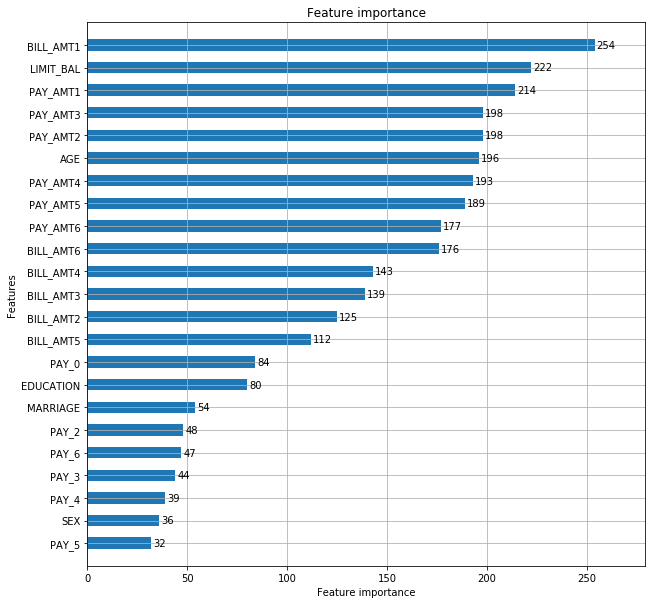

In [281]:
fig,ax = plt.subplots(figsize=(10,10))
lgb.plot_importance(clf,height=0.5,ax=ax)

## Predict the target values

In [279]:
# Use the whole data set to train our model
clf = lgb.LGBMClassifier()
clf.fit(train_X, train_Y)

# predict the results
preds_Y=clf.predict(test_X)

## Confusion matrix, accuracy, precision, recall, F1 score

In [280]:
preds_Y=(preds_Y>0.5).astype(int)

accuracy = accuracy_score(test_Y, preds_Y)
precision = precision_score(test_Y, preds_Y)
recall = recall_score(test_Y, preds_Y)
f1 = f1_score(test_Y, preds_Y)
c_matrix = confusion_matrix(test_Y, preds_Y)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.825

precision: 0.7292576419213974

recall: 0.367032967032967

F1 score: 0.48830409356725146

Confusion matrix: 
[[4449  186]
 [ 864  501]]


# DNN model

One thing to note is that, we use the whole training data and the "validation_split" parameter when we fit our model. We use "validation_split" to automatically create our validation set. 

In [384]:
from keras import models
from keras import layers

## Data scaling: Standardization

I use data scaling in order to improve the stability and performance of DNN models.

Reference: https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

**Remark:** in general, in tree-based models the scale of the features does not matter.

Reference: https://datascience.stackexchange.com/questions/22036/how-does-lightgbm-deal-with-value-scale

Reference: https://datascience.stackexchange.com/questions/16225/would-you-recommend-feature-normalization-when-using-boosting-trees

Now, let's scale our training set and test set.

Reference: https://datascience.stackexchange.com/questions/39932/feature-scaling-both-training-and-test-data

In [385]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit(OH_train_X) # Use the whole train set to fit our standardscaler.

OH_train_X = sc.transform(OH_train_X)
OH_test_X = sc.transform(OH_test_X)

# Transform dataframe to array, so we can use our DNN models.
OH_train_X = np.asarray(OH_train_X)
OH_test_X = np.asarray(OH_test_X)
train_Y = np.asarray(train_Y)

## Calculated class weight

In [386]:
data_df["default.payment.next.month"].value_counts()

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

In [387]:
# Calculate class weight
NotDefault = 23364
Default = 6636
total_count = 23364 + 6636

weight_no_default = (1/NotDefault)*(total_count)/2.0
weight_default = (1/Default)*(total_count)/2.0

class_weights = {0:weight_no_default, 1:weight_default}


## Model1

Goal: get great results in training set.

In [478]:
# Training the DNN model 1
model = models.Sequential()
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(OH_train_X,
                    train_Y,
                    epochs=200,
                    batch_size=50,
                    validation_split=0.2,
                    class_weight = class_weights) # Note that the "validation_split" parameter

Train on 19200 samples, validate on 4800 samples
Epoch 1/200
19200/19200 [==============================] - 2s 116us/step - loss: 0.5984 - accuracy: 0.7478 - val_loss: 0.5945 - val_accuracy: 0.7667
Epoch 2/200
19200/19200 [==============================] - 2s 83us/step - loss: 0.5762 - accuracy: 0.7586 - val_loss: 0.5817 - val_accuracy: 0.7475
Epoch 3/200
19200/19200 [==============================] - 2s 83us/step - loss: 0.5665 - accuracy: 0.7609 - val_loss: 0.5852 - val_accuracy: 0.7004
Epoch 4/200
19200/19200 [==============================] - 2s 84us/step - loss: 0.5609 - accuracy: 0.7487 - val_loss: 0.5837 - val_accuracy: 0.7460
Epoch 5/200
19200/19200 [==============================] - 2s 92us/step - loss: 0.5545 - accuracy: 0.7565 - val_loss: 0.5924 - val_accuracy: 0.6615
Epoch 6/200
19200/19200 [==============================] - 2s 87us/step - loss: 0.5540 - accuracy: 0.7560 - val_loss: 0.5899 - val_accuracy: 0.7340
Epoch 7/200
19200/19200 [==============================] - 2s 

## Plot the results of loss and accuracy

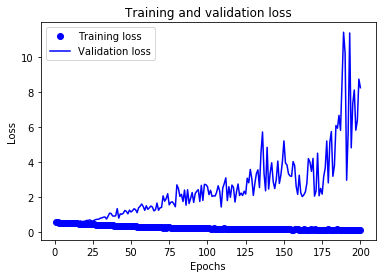

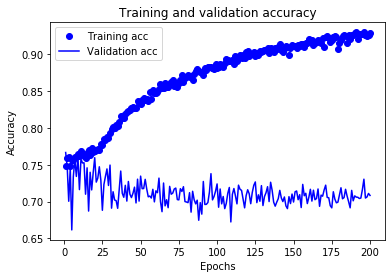

In [479]:
# plot the results of loss values from the training set and validtion set
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') # bo is for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # b is for blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

According to above plots, we find that we have significant overfitting problem. (The validation loss is out of control).

Therefore, let's use the 'dropout' techiniques in our next DNN model to prevent this problem.

## Model2

Let's use the 'dropout' techiniques to prevent this problem.

In [504]:
# Training the DNN model 2
# Use "dropout" to prevent overfitting
model = models.Sequential()
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(OH_train_X,
                    train_Y,
                    epochs=200,
                    batch_size=50,
                    validation_split=0.2,
                    class_weight = class_weights) # Note that the "validation_split" parameter

Train on 19200 samples, validate on 4800 samples
Epoch 1/30
19200/19200 [==============================] - 3s 165us/step - loss: 0.6858 - accuracy: 0.5519 - val_loss: 0.6953 - val_accuracy: 0.7783
Epoch 2/30
19200/19200 [==============================] - 3s 155us/step - loss: 0.6393 - accuracy: 0.7455 - val_loss: 0.6995 - val_accuracy: 0.7873
Epoch 3/30
19200/19200 [==============================] - 2s 118us/step - loss: 0.6207 - accuracy: 0.7506 - val_loss: 0.6773 - val_accuracy: 0.8062
Epoch 4/30
19200/19200 [==============================] - 2s 118us/step - loss: 0.6127 - accuracy: 0.7333 - val_loss: 0.6730 - val_accuracy: 0.8108
Epoch 5/30
19200/19200 [==============================] - 2s 119us/step - loss: 0.6064 - accuracy: 0.7348 - val_loss: 0.6872 - val_accuracy: 0.8102
Epoch 6/30
19200/19200 [==============================] - 2s 113us/step - loss: 0.6016 - accuracy: 0.7289 - val_loss: 0.6789 - val_accuracy: 0.8140
Epoch 7/30
19200/19200 [==============================] - 2s 11

## Plot the results of loss and accuracy

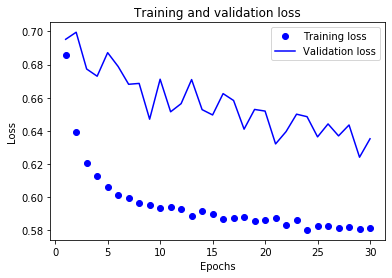

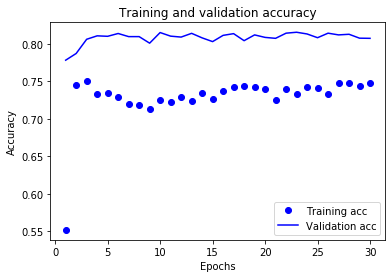

In [505]:
# plot the results of loss values from the training set and validtion set
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') # bo is for blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') # b is for blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

According to above plots, we have overcome the overfitting problem. That's great!

## Use the whole training set to train our DNN model

Now, let's use the whole training set to train our DNN model .

In [509]:
# Try
# Using whole training data to train our model

model = models.Sequential()
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(OH_train_X,
                    train_Y,
                    epochs=200,
                    batch_size=50,
                    class_weight = class_weights)

Epoch 1/200
24000/24000 [==============================] - 4s 171us/step - loss: 0.6757 - accuracy: 0.5931
Epoch 2/200
24000/24000 [==============================] - 2s 102us/step - loss: 0.6343 - accuracy: 0.7444
Epoch 3/200
24000/24000 [==============================] - 3s 109us/step - loss: 0.6138 - accuracy: 0.7359
Epoch 4/200
24000/24000 [==============================] - 2s 100us/step - loss: 0.6084 - accuracy: 0.7309
Epoch 5/200
24000/24000 [==============================] - 3s 121us/step - loss: 0.6052 - accuracy: 0.7268
Epoch 6/200
24000/24000 [==============================] - 3s 116us/step - loss: 0.5990 - accuracy: 0.7132
Epoch 7/200
24000/24000 [==============================] - 2s 98us/step - loss: 0.5988 - accuracy: 0.7145
Epoch 8/200
24000/24000 [==============================] - 2s 96us/step - loss: 0.5983 - accuracy: 0.7154
Epoch 9/200
24000/24000 [==============================] - 2s 97us/step - loss: 0.5929 - accuracy: 0.7193
Epoch 10/200
24000/24000 [==============

## predict the target values of testing set.

In [516]:
preds_Y = model.predict(OH_test_X)
preds_Y=(preds_Y>0.5).astype(int)

## Confusion matrix, accuracy, precision, recall, F1 score

In [510]:
accuracy = accuracy_score(test_Y, preds_Y)
precision = precision_score(test_Y, preds_Y)
recall = recall_score(test_Y, preds_Y)
f1 = f1_score(test_Y, preds_Y)
c_matrix = confusion_matrix(test_Y, preds_Y)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8075

precision: 0.5908304498269896

recall: 0.5003663003663004

F1 score: 0.5418484728282427

Confusion matrix: 
[[4162  473]
 [ 682  683]]


# Conclusion

In this report, we use different machine learning models to predict default of credit cards next month:

CatBoost, XGBoost, LightGBM, Deep Neural Networks (DNN model).

To apply different models, I did various data pre-processing, such as one-hot encoding and standarization.

By using CatBoost, XGBoost, and LightGBM, we can get accuracy above 80% in our testing set.

By using DNN models, we have lots of flexibility of network architecture. In particular, by using "dropout" techniques and enough training epochs, we can get pretty great result in our testing set.

## Compare different models

### CatBoost:

accuracy: 0.8221666666666667

precision: 0.7217261904761905

recall: 0.3553113553113553

F1 score: 0.47619047619047616

### XGBoost:

accuracy: 0.8188333333333333

precision: 0.7044117647058824

recall: 0.3509157509157509

F1 score: 0.4684596577017115

### LightGBM:
accuracy: 0.825

precision: 0.7292576419213974

recall: 0.367032967032967

F1 score: 0.48830409356725146


### DNN model:
accuracy: 0.8075

precision: 0.5908304498269896

recall: 0.5003663003663004

F1 score: 0.5418484728282427


According to above information, our DNN model is the best model in terms of F1 score. 

One thing to note is that, because we are dealing with imbalanced dataset, F1 score will be a more reasonable metric than accuracy. Therefore, in this report, DNN model will be the best model when we want to predict default of credit cards next month.

## Future works

In our future work, I will spend more time to tune the hyperparameters in our DNN models, such as numbers of hidden layers and units.

Hopefully, we can get even better results by using DNN models after tuning the hyperparameters.